In [71]:
import sys
import os

import numpy as np
import scipy as sp
#import scipy.signal as sig

import matplotlib as mpl
import matplotlib.pyplot as plt

from matplotlib import animation, rc
from IPython.display import HTML

import matplotlib.cm as cm

import cvxopt

import cvxpy as cvx

%matplotlib notebook


status: optimal
optimal value 1857.34305514
(2, 10)


<IPython.core.display.Javascript object>


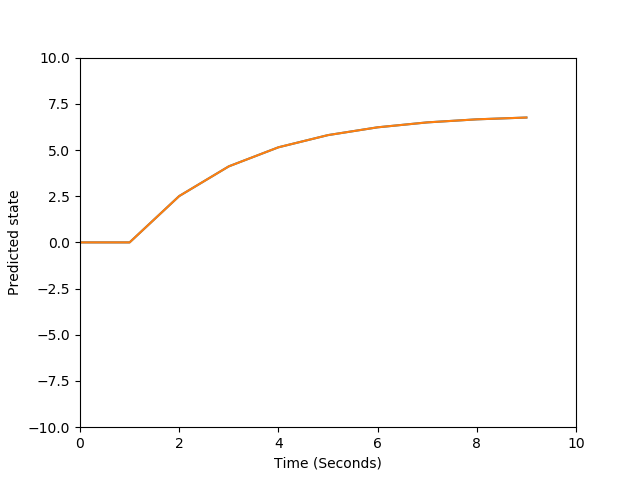

<IPython.core.display.Javascript object>


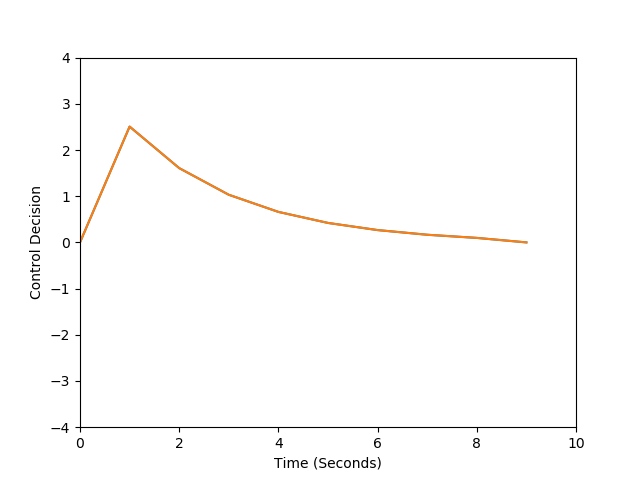

In [72]:
T = 10 # seconds, the time horizon of optimisation 
dt = 1 #seconds, the time step of optimisation 

#size of the storage for all the values of different signals
ssize = int(T/dt) 

# x_i is added as a vector of variables to the problem 
x_pred = cvx.Variable(  2,ssize )



# u_i is added as a vector of variables to the problem 
u_plan = cvx.Variable( 2,ssize)

# adding the state space constraints  
constraints = [ ]

#adding the initial conditions
constraints.append (x_pred[:,0] == [0,0])
constraints.append (u_plan[:,0] == [0,0])

constraints.append (x_pred <= 10)
constraints.append (x_pred >= -10)

constraints.append (u_plan <= 3)
constraints.append (u_plan >= -3)


for i in range (ssize-1):
    constraints.append (x_pred[:,i+1] == x_pred[:,i] + u_plan[:,i])
    
    

# the time-varying part of cost is m*(x - target) 
# m starts low and keeps building up if target is not approached
m = 0
target = [-7,-7]
# if target is acheived there is more tendency to go home via the cost n*(x-home)
n = 5
home = [7,7]


# objective function
ObjFunc =   cvx.Minimize(  sum(
                                cvx.norm(n* u_plan[:,i], 2)**2 +
                                n * cvx.norm(x_pred[:,i]-home,2)**2 +
                                m * cvx.norm(x_pred[:,i]-target,2)**2
                           for i in range(ssize)) + 
                           n * cvx.norm(x_pred[:,-1]-home,2)**2 
                        )

prob = cvx.Problem(ObjFunc, constraints)
prob.solve() 
print "status:", prob.status
print "optimal value", prob.value
print np.shape(x_pred.value)


fig1a = plt.figure()
plt.plot(x_pred.value.T )
plt.ylabel('Predicted state')
plt.xlabel('Time (Seconds)')
plt.axis([0, ssize, -10, 10])
plt.show()

fig1b = plt.figure()
plt.plot(u_plan.value.T)
plt.ylabel('Control Decision')
plt.xlabel('Time (Seconds)')
plt.axis([0, ssize, -4, 4])
plt.show()





## MPC Strategy 


In [73]:


# actual simulation time horizon 
T_Sim = 200

# size of the storage variables dt is the same as the time step for point optimisation
size_Sim = int (T_Sim/dt )

# the horizon for planning/optimisation
T_Opt = 2

# initialising the storage array for the variables of the problem
x_sim = np.zeros((2, size_Sim))
x_sim_0  = np.zeros((1, 2))
x_sim[:,0] = x_sim_0 


x_pred_sim = np.zeros((2, size_Sim))
x_pred_sim_0  = np.zeros((1, 2))
x_pred_sim[:,0] = x_pred_sim_0 

u_sim = np.ones((2, size_Sim))
u_sim_0  = np.zeros((1, 2))
u_sim[:,0] = u_sim_0 



# this is the main loop of the simulation 
i = 0
while (i <= size_Sim - T_Opt - 1):
    
    
    # replace the initial conditions for the solver
    

    prob.constraints[0] = (x_pred[0,0] == x_sim[0,i])
    prob.constraints[1] = (x_pred[1,0] == x_sim[1,i])
    prob.constraints[2] = (u_plan[0,0] == u_sim[0,i])
    prob.constraints[3] = (u_plan[1,0] == u_sim[1,i])

    
    
    
    
    #solve for the next N steps
    prob.solve()
    
    # this is the execution loop of the simulation in which for T_Opt steps
    # the plan of the planner is applied to the simulated system
    for j in range (T_Opt - 1):
        
        
        #reading the plan from the solver 
        u_sim[:,i+j] = (u_plan.value[:,j]).T
        
        
        #disturbance signal randint returns uniformly probable an integer between [lower upper) upper not included.  
        d = np.random.uniform(-.5,.6,[1,2]) 
        
        
        # how the actual system is simulated 
        x_sim[:,i+j+1] = x_sim[:,i+j] + u_sim[:,i+j] + d 
        
        
        
        # storing what the planner had predicted for the states
        x_pred_sim[:,i+j+1] = (x_pred.value[:,j+1]).T
        
        
    
    # house keeping for the interplay of the inner and outer loop (you can ignore these)
    i = i + T_Opt - 1    
    u_sim[:,i] = u_sim[:,i - 1]
    print np.linalg.norm(x_sim[:,i]-[target],2)
    
    if (np.linalg.norm(x_sim[:,i]-target,2) > .5):
        m= m + 1
    else:
        m = 0
        
    prob.objective =  cvx.Minimize (sum(
                                        cvx.norm(n* u_plan[:,k], 2)**2 +
                                        n* cvx.norm(x_pred[:,k]-home,2)**2 +
                                        m * cvx.norm(x_pred[:,k]-target,2)**2
                                    for k in range(ssize)) + 
                                    n * cvx.norm(x_pred[:,-1]-home,2)**2 )
                        
    
    
    





9.56126459942
9.42119235478
9.45761583261
9.21779008188
9.3672517357
9.87910866913
10.3579286377
10.8843577217
10.573469204
10.7223991975
10.8927339685
10.7932439066
11.1455002948
11.0234777623
11.4449635661
11.1064893452
11.4070339156
11.6065899858
11.4878257978
11.478165554
11.4013153815
11.8795786056
11.7899121674
12.2328969742
12.5558457784
12.862123832
12.8720370786
13.3934503448
13.2654589118
13.332396362
13.3747852008
13.1725601633
13.006815994
12.8058691349
12.6001897086
12.0455464308
11.7759217672
12.1016927139
12.0349173055
11.6824695544
12.0749200637
12.1977679984
11.94255768
12.4414685371
12.4965372738
12.3228938319
11.9511763963
11.7649298513
12.518603342
12.1333582605
12.1192469083
12.0529935612
11.9056514291
11.5867141841
11.9170958547
12.3414442993
12.3558345544
12.1731884128
12.0611230023
12.2431908527
12.6019835066
12.5277158248
12.4605787296
12.8400680348
13.1207382629
13.6195228682
13.2477671388
13.0639151224
12.5663265189
12.8247966731
13.0699408014
13.3528371364
1

<IPython.core.display.Javascript object>


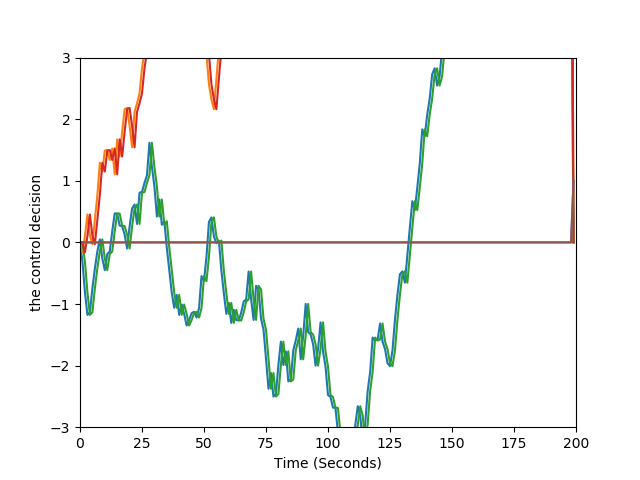

In [74]:
# Plotting the results
fig2 = plt.figure()
plt.plot(x_sim.T)
plt.ylabel('state of simulated system')
plt.xlabel('Time (Seconds)')
plt.axis([0, size_Sim, -10, 10])
plt.show()

plt.plot(x_pred_sim.T)
plt.ylabel('state of the system as predicted by Planner')
plt.xlabel('Time (Seconds)')
plt.axis([0, size_Sim, -10, 10])
plt.show()

plt.plot(u_sim.T)
plt.ylabel('the control decision')
plt.xlabel('Time (Seconds)')
plt.axis([0, size_Sim, -3, 3])
plt.show()



<IPython.core.display.Javascript object>


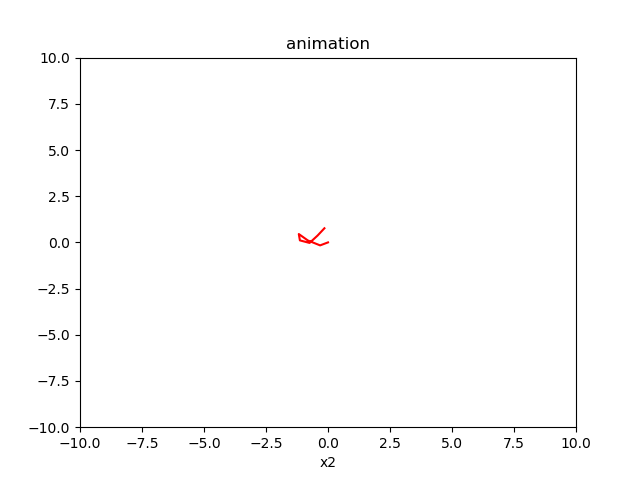

In [75]:
# Animation 





def update_line(num, data, line):
    line.set_data(data[..., :num])
    return line,

fig3 = plt.figure()


data = x_sim

l, = plt.plot([], [], 'r-')
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.xlabel('x1')
plt.xlabel('x2')
plt.title('animation')

line_ani = animation.FuncAnimation(fig2, update_line, size_Sim, fargs=(data, l),
                                   interval=100, blit=True)
#HTML(line_ani.to_jshtml())